# Makemore: Wavenet

- [Andrej Karpathy YouTube](https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6&ab_channel=AndrejKarpathy)

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [4]:
def load_data(file_path: str) -> list[str]:
    """Load text data from a file and return as a list of strings."""

    with open(file_path, "r") as f:
        # Read all the lines as a list
        data: list[str] = f.read().splitlines()

    return data

In [5]:
# Load Data
fp: str = "../../../data/names.txt"
names: list[str] = load_data(file_path=fp)

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

### Build Vocabulary Of Characters And Mappings

In [6]:
special_token: str = "."
characters: list[str] = sorted(set("".join(names)))
# Add the special token to the beginning of the list.
characters.insert(0, special_token)
n_chars: int = len(characters)

# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(characters)}
# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}

In [7]:
from torch.utils.data import random_split, TensorDataset, Dataset
from sklearn.model_selection import train_test_split


def build_dataset(
    names: list[str],
    special_token: str = ".",
    block_size: int = 3,
    print_info: bool = False,
) -> tuple[Tensor, Tensor]:
    """
    Builds a dataset of name sequences and their corresponding character indices.

    Args:
        names (list[str]): A list of names to build the dataset from.
        special_token (str, optional): A special token to append to the end of each name. Defaults to ".".
        block_size (int, optional): The size of the context window for each input sequence. Defaults to 3.
        print_info (bool, optional): Whether to print information about the dataset generation. Defaults to False.

    Returns:
        tuple[Tensor, Tensor]: A tuple containing the input sequences (X) and their corresponding target indices (Y).
    """
    X, Y = [], []

    for w in names:
        if print_info:
            print(w)
        context: list[str] = [0] * block_size

        for ch in w + special_token:
            ix: int = text_to_num.get(ch)
            X.append(context)
            Y.append(ix)

            if print_info:
                print(
                    f"{''.join([num_to_text.get(i) for i in context])} ---> {num_to_text.get(ix)}"
                )

            # Crop and append, like a rolling window
            context = context[1:] + [ix]

    X: Tensor = torch.tensor(X)
    Y: Tensor = torch.tensor(Y)
    print(f"\n{X.shape=}, {Y.shape=}")
    return (X, Y)


def split_data_into_train_dev_test(
    data: Tensor | Dataset, test_size: float = 0.05, dev_size: float = 0.1, seed=42
) -> tuple[Tensor, ...]:
    """
    Splits a given PyTorch tensor `data` into training, development, and test sets.

    Params:
    -------
        data (torch.Tensor): The input tensor to be split.
        test_size (float, optional): The fraction of the data to use for the test set. Defaults to 0.2.
        dev_size (float, optional): The fraction of the data to use for the development set. Defaults to 0.1.
        seed (int, optional): The random seed to use for reproducibility. Defaults to 42.

    Returns:
    --------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The training, development, and test sets as PyTorch tensors.
    """
    if isinstance(data, Tensor):
        X_train, X_test = train_test_split(data, test_size=test_size, random_state=seed)
        X_train, X_dev = train_test_split(
            X_train, test_size=dev_size, random_state=seed
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test)
    if isinstance(data, Dataset):
        X_train, X_test, y_train, y_test = train_test_split(
            data.data,
            data.targets,
            test_size=test_size,
            random_state=seed,
            stratify=data.targets,
        )
        X_train, X_dev, y_train, y_dev = train_test_split(
            X_train, y_train, test_size=dev_size, random_state=seed, stratify=y_train
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test, y_train, y_dev, y_test)

    print(f"{X_train.shape=}; {X_dev.shape=}; {X_test.shape=}")

    return result


class MyDataset(Dataset):
    def __init__(self, data: Tensor, targets: Tensor) -> None:
        self.data = data
        self.targets = targets

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(data.shape={self.data.shape}, "
            f"target.shape={self.targets.shape=})"
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

In [8]:
from abc import ABC, abstractmethod


class CustomModule(ABC):
    @abstractmethod
    def __init__(self) -> None:
        raise NotImplementedError

    @abstractmethod
    def __repr__(self) -> str:
        raise NotImplementedError

    @abstractmethod
    def __call__(self, x: Tensor) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def parameters(self) -> list[Tensor]:
        raise NotImplementedError


class Linear(CustomModule):
    """
    A linear layer implementation.

    This class implements a linear layer, which performs a linear transformation on the input tensor. It takes in the number
    of input features and output features, and optionally a bias term. The weights and biases are initialized randomly.

    The `__call__` method applies the linear transformation to the input tensor and returns the output tensor.

    The `parameters` method returns a list of the learnable parameters (weights and biases) of the layer.
    """

    def __init__(
        self, in_features: int, out_features: int, bias: bool = True, seed: int = 42
    ) -> None:
        self.in_features = in_features
        self.out_features = out_features
        # Kaiming's initialization
        self.weight = (
            torch.randn(in_features, out_features, generator=torch.manual_seed(seed))
            / in_features**0.5
        )
        self.bias = (
            torch.randn(out_features, generator=torch.manual_seed(seed))
            if bias
            else None
        )

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"

    def __call__(self, x: Tensor) -> Tensor:
        self.output: Tensor = torch.matmul(x, self.weight)
        if self.bias is not None:
            self.output += self.bias
        return self.output

    def parameters(self) -> list[Tensor]:
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class BatchNorm1d(CustomModule):
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

    def __call__(self, x: Tensor) -> Tensor:
        if self.training:
            if x.ndim == 2:
                dim: tuple[int] | int = 0
            elif x.ndim == 3:
                dim = (0, 1)
            # Calculate the batch mean and variance
            x_mean: Tensor = x.mean(dim=dim, keepdim=True)
            x_var: Tensor = x.var(dim=dim, keepdim=True)

        else:
            x_mean = self.running_mean
            x_var = self.running_var

        # Normalize the input
        x_hat: Tensor = (x - x_mean) / (x_var + self.eps).sqrt()
        self.output: Tensor = (self.gamma * x_hat) + self.beta

        if self.training:
            with torch.no_grad():
                # Update running mean and variance
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * x_mean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * x_var

        return self.output

    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]


class Tanh(CustomModule):
    """A custom module that applies the hyperbolic tangent activation function to the input tensor."""

    def __init__(self) -> None:
        pass

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

    def __call__(self, x: Tensor) -> Tensor:
        self.output = torch.tanh(x)
        return self.output

    def parameters(self) -> list[Tensor]:
        return []


class Embedding(CustomModule):
    """A custom module that creates an embedding lookup table from a given
    vocabulary size and embedding dimension."""

    def __init__(self, vocab_size: int, embedding_dim: int, seed: int = 42) -> None:
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.weight = torch.randn(
            (vocab_size, embedding_dim), generator=torch.manual_seed(seed)
        )

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.vocab_size}, {self.embedding_dim})"

    def __call__(self, idx: int) -> Tensor:
        self.output = self.weight[idx]
        return self.output

    def parameters(self) -> list[Tensor]:
        """Get all the parameters."""
        return [self.weight]


class Flatten(CustomModule):

    def __init__(self) -> None:
        pass

    def __repr__(self) -> str:
        return f"{__class__.__name__}()"

    def __call__(self, x: Tensor) -> Tensor:
        self.output = x.view(x.shape[0], -1)
        return self.output

    def parameters(self):
        """Get all the parameters."""
        return []


class Sequential(CustomModule):
    """A custom module that applies a sequence of other custom modules to the input tensor."""

    def __init__(self, layers: list[CustomModule]) -> None:
        self.layers = layers

    def __repr__(self) -> str:
        return f"{__class__.__name__}({len(self.layers)})"

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        """Get parameters of all layers and stretch them out into one list."""
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
X, y = build_dataset(names=names[:5], block_size=3, print_info=True)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .

X.shape=torch.Size([32, 3]), Y.shape=torch.Size([32])


In [10]:
X, y = build_dataset(names=names, block_size=3, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 3]); X_dev.shape=torch.Size([21675, 3]); X_test.shape=torch.Size([11408, 3])


### Experiment!

- 1

In [11]:
# Parameters
g = torch.Generator().manual_seed(5)

emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 140_000  # number of epochs

layers: list[Any] = [
    Embedding(vocab_size=n_chars, embedding_dim=emb_dim, seed=42),
    Flatten(),
    Linear(in_features=M, out_features=n_nodes, bias=False),
    BatchNorm1d(dim=n_nodes),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_chars, bias=False),
    BatchNorm1d(dim=n_chars),
]

with torch.no_grad():
    # Make last layer less confident
    # layers[-1].weight *= 0.1  # Default: w/o BatchNorm
    layers[-1].gamma *= 0.1  # with BatchNorm

    # Apply gain to the other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # Scale the weights of all other linear layers by a gain factor.
            # layer.weight *= 5 / 3 # Default: w/o BatchNorm
            layer.weight *= 1.0  # with BatchNorm: No scaling

# Parameters Collection
parameters: list[Tensor] = [p for layer in layers for p in layer.parameters()]
print(f"Total params: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Total params: 18,024


In [12]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))
    # X, y batch
    Xb, yb = X_train[idx], y_train[idx]

    # Forward pass
    x: Tensor = Xb
    for layer in layers:
        x: Tensor = layer(x)  # Logits: Apply the linear layer
    loss: Tensor = F.cross_entropy(x, yb)

    # Backward pass
    for p in parameters:
        # Reset gradients
        p.grad = None
    loss.backward()

    # learning rate decay
    learning_rate: float = (
        0.1 if epoch < 70_000 else (0.01 if epoch < 85_000 else 0.001)
    )

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

    if epoch > 100:
        break

Epoch: 0/140000 | Loss: 3.3159


In [13]:
# Embeddings of index 2
layers[0](2)

tensor([-0.7592,  1.0786,  0.8008,  1.6781,  1.2758,  1.2908,  0.6107,  1.3340,
        -0.2326,  0.0402], grad_fn=<SelectBackward0>)

In [14]:
# Sample from the model

for layer in layers:
    layer.training = False


g = torch.Generator().manual_seed(5)
n_names: int = 10

for _ in range(n_names):

    out: list[str] = []
    context: list[int] = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        x: Tensor = torch.tensor([context])

        for layer in layers:
            x = layer(x)

        logits: Tensor = x
        probs: Tensor = F.softmax(logits, dim=1)
        # sample from the distribution
        idx: int = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [idx]
        out.append(idx)
        # If we sample the special '.' token, break
        if idx == 0:
            break

    # Decode and print the generated word
    print("".join(num_to_text.get(i) for i in out))

kafyuw.
.
parales.
zfgfixo.
erihrbvblxf.
yfp.
ajnven.
opzioa.
medai.
huccndarnldesqucdicucunnye.


### Experiment 2!

- The current inplementation flattens the entire data into a 2-D array which is not optimal when the block_size is large.

```py
# e.g. If the block_size is 3
```

<br>

- Implement the [Wavenet](https://arxiv.org/pdf/1609.03499) architecture shown below:

<img src="../images/Wavenet.png" width="500">

- The input is combined to form several bigrams which are further combined at every layer in the network.
  - i.e. if you have 8 characters in the input layer, you will have 4 bigrams (e.g. `ab`, `cd`, `ef`, `gh`).
  - `ab` is combined with `cd` to form `abcd`, `ef` is combined with `gh` to form `efgh` and so on.
  - finally, `abcd` and `efgh` are combined and used to predict the output.

<br><hr>

```text
Combining each input layer with the next one to form bigrams:

FlattenConsecutive(2):   (4, 4, 20)   # i.e. 4 groups (1 2)   (3 4)   (5 6)   (7 8) 
...
FlattenConsecutive(2):   (4, 2, 600)   # i.e. 2 groups (1 2 3 4)   (5 6 7 8) 
...
FlattenConsecutive(2):   (4, 600)   # (4, 1, 600) i.e. 1 group (1 2 3 4 5 6 7 8) 

```

In [15]:
# Parameters
g = torch.Generator().manual_seed(5)

emb_dim: int = 10  # embedding dimension
block_size: int = 8  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 140_000  # number of epochs

# NEW!
model: Sequential = Sequential(
    layers=[
        Embedding(vocab_size=n_chars, embedding_dim=emb_dim, seed=42),
        Flatten(),
        Linear(in_features=M, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        Linear(in_features=n_nodes, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        Linear(in_features=n_nodes, out_features=n_chars, bias=True),
    ]
)

with torch.no_grad():
    # Make last layer less confident
    model.layers[-1].weight *= 0.1  # Default: w/o BatchNorm

# Parameters Collection
parameters: list[Tensor] = model.parameters()  # NEW!
print(f"Total params: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Total params: 123,597


In [16]:
X, y = build_dataset(names=names, block_size=block_size, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 8]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 8]); X_dev.shape=torch.Size([21675, 8]); X_test.shape=torch.Size([11408, 8])


In [17]:
# 8 characters are required to predict the next character
build_dataset(names=names[:2], block_size=block_size, print_info=True)

emma
........ ---> e
.......e ---> m
......em ---> m
.....emm ---> a
....emma ---> .
olivia
........ ---> o
.......o ---> l
......ol ---> i
.....oli ---> v
....oliv ---> i
...olivi ---> a
..olivia ---> .

X.shape=torch.Size([12, 8]), Y.shape=torch.Size([12])


(tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  5],
         [ 0,  0,  0,  0,  0,  0,  5, 13],
         [ 0,  0,  0,  0,  0,  5, 13, 13],
         [ 0,  0,  0,  0,  5, 13, 13,  1],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 15],
         [ 0,  0,  0,  0,  0,  0, 15, 12],
         [ 0,  0,  0,  0,  0, 15, 12,  9],
         [ 0,  0,  0,  0, 15, 12,  9, 22],
         [ 0,  0,  0, 15, 12,  9, 22,  9],
         [ 0,  0, 15, 12,  9, 22,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

In [18]:
batch_size: int = 4
idx: Tensor = torch.randint(0, X_train.shape[0], (batch_size,))
X_s, y_s = X_train[idx], y_train[idx]
logits: Tensor = model(X_s)
print(f"{X_s.shape = }")

# 4 samples each containing a block size of `block_size`
X_s

X_s.shape = torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  5, 12,  9, 19],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 15, 12],
        [ 0,  0,  1,  4,  4, 25, 12,  9]])

<br><hr>

```py
M: int = emb_dim * block_size  # number of inputs

model: Sequential = Sequential(
    layers=[
        Embedding(vocab_size=n_chars, embedding_dim=emb_dim, seed=42), # 1st layer
        Flatten(),  # 2nd layer
        Linear(in_features=M, out_features=n_nodes, bias=False), # 3rd layer
        BatchNorm1d(dim=n_nodes), # 4th layer
        Tanh(),  
        Linear(in_features=n_nodes, out_features=n_chars, bias=False),
        BatchNorm1d(dim=n_chars), 
    ]
)
```
<hr>

In [19]:
model.layers

[Embedding(27, 10),
 Flatten(),
 Linear(80, 300),
 BatchNorm1d(),
 Tanh(),
 Linear(300, 300),
 BatchNorm1d(),
 Tanh(),
 Linear(300, 27)]

In [20]:
# 1st layer: Output of Embedding layer
model.layers[0].output.shape  # (Batch_size, block_size, emb_dim)

torch.Size([4, 8, 10])

In [21]:
# 2nd layer: Output of Flatten layer
# It has been reshaped to ( batch_size, (block_size, emb_dim) ) from (batch_size, block_size, emb_dim)
# It was flattened because the next (Linear) layer expects a 2-D input
model.layers[1].output.shape

torch.Size([4, 80])

In [22]:
# 3rd layer: Output of Linear layer
# Matrix Multiplication of the input with the weights
model.layers[2].output.shape  # (batch_size, block_size) @ (block_size, n_nodes)

torch.Size([4, 300])

In [23]:
# 4th layer: Output of BatchNorm layer
# Normalize the output of the previous layer
model.layers[3].output.shape  # (batch_size, block_size) @ (block_size, n_nodes)

torch.Size([4, 300])

In [24]:
# The current implementation of the Linear Layer
# (4, 8, 10) is flattened to (4, 80)
# (4, 80) @ (80, 300) + (300,) => (4, 300)
(
    torch.randn((4, block_size * emb_dim))  # (4, 80)
    @ torch.randn((block_size * emb_dim, n_nodes))  # (80, 300)
    + torch.randn(n_nodes)  # (300,)
).shape

torch.Size([4, 300])

In [25]:
# Implement Wavenet
#   1       2       3       4     i.e.  n_combined_input = 4 groups
# (1 2)   (3 4)   (5 6)   (7 8)
# i.e. we want: (batch_size, n_combined_input, -1)
# i.e. from (4, 8, 10) to (4, 4, 20) instead of (4, 80)

res_1: Tensor = torch.randn((4, block_size * emb_dim)).view(
    4, -1, (block_size * emb_dim) // 4
)
# OR
res_2: Tensor = torch.randn((4, block_size * emb_dim)).view(
    4, block_size // 2, (emb_dim * 2)
)
print(f"{res_1.shape = }")
print(f"{res_2.shape = }")

res_1.shape = torch.Size([4, 4, 20])
res_2.shape = torch.Size([4, 4, 20])


In [26]:
class FlattenConsecutive(CustomModule):
    """A custom module that flattens consecutive elements in the input tensor along
    the second dimension."""

    def __init__(self, n_c_elements: int) -> None:
        """
        Note:
            n_c_elements: the number of consecutive elements to concatenate.
        """
        self.n_c_elements = n_c_elements

    def __repr__(self) -> str:
        return f"{__class__.__name__}({self.n_c_elements})"

    def __call__(self, x: Tensor) -> Tensor:
        # B: batch size, L: sequence length, C: number of channels
        B, L, C = x.shape
        assert (
            L % self.n_c_elements == 0
        ), f"The length of the input tensor must be a multiple of {self.n_c_elements}."

        x = x.view(B, L // self.n_c_elements, C * self.n_c_elements)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.output = x
        return self.output

    def parameters(self):
        """Get all the parameters."""
        return []


def calculate_loss_upd(X: Tensor, y: Tensor, training: True) -> Tensor:
    """
    Calculates the loss for the given input tensors `X` and `y`.

    Args:
        X (torch.Tensor): The input tensor.
        y (torch.Tensor): The target tensor.
        training (bool): Indicates whether the model is in training mode or not.

    Returns:
        torch.Tensor: The calculated loss.
    """

    # Set the training mode to False
    for layer in model.layers:
        if hasattr(layer, "training"):
            layer.training = False

    with torch.no_grad():
        # Forward pass
        logits: Tensor = model(X)

        # Calculate the loss
        loss: Tensor = F.cross_entropy(logits, y)
        result: str = (
            f"Training loss: {loss:.4f}" if training else f"Validation loss: {loss:.4f}"
        )
        print(result)

        return loss

In [27]:
res_1: Tensor = torch.randn(4, block_size, emb_dim)
fl = FlattenConsecutive(n_c_elements=2)
# Concatenate 2 consecutive elements. i.e. (1 2), (3 4), (5 6), (7 8)
print(f"{res_1.shape = }")
print(f"{fl(res_1).shape = }")

res_1.shape = torch.Size([4, 8, 10])
fl(res_1).shape = torch.Size([4, 4, 20])


In [28]:
res_2: Tensor = torch.randn(4, block_size, emb_dim)
fl = FlattenConsecutive(n_c_elements=4)
# Concatenate 4 consecutive elements. i.e. (1 2 3 4), (5 6 7 8) etc
print(f"{res_2.shape = }")
print(f"{fl(res_2).shape = }")

res_2.shape = torch.Size([4, 8, 10])
fl(res_2).shape = torch.Size([4, 2, 40])


In [29]:
# Parameters
g = torch.Generator().manual_seed(5)

emb_dim: int = 10  # embedding dimension
block_size: int = 8  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 64  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 140_000  # number of epochs

# NEW!
n_c_elements: int = 2
model: Sequential = Sequential(
    layers=[
        Embedding(vocab_size=n_chars, embedding_dim=emb_dim, seed=42),
        # ===
        FlattenConsecutive(n_c_elements=n_c_elements),
        Linear(in_features=emb_dim * n_c_elements, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        # === layer 1
        FlattenConsecutive(n_c_elements=n_c_elements),
        Linear(in_features=n_nodes * n_c_elements, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        # === layer 2
        FlattenConsecutive(n_c_elements=n_c_elements),
        Linear(in_features=n_nodes * n_c_elements, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        # === layer 3
        Linear(in_features=n_nodes, out_features=n_chars),
    ]
)

with torch.no_grad():
    # Make last layer less confident
    model.layers[-1].weight *= 0.1  # Default: w/o BatchNorm

# Parameters Collection
parameters: list[Tensor] = model.parameters()  # NEW!
print(f"Total params: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Total params: 20,073


In [30]:
X, y = build_dataset(names=names, block_size=block_size, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)

print()

batch_size: int = 4
idx: Tensor = torch.randint(0, X_train.shape[0], (batch_size,))
X_s, y_s = X_train[idx], y_train[idx]
logits: Tensor = model(X_s)
print(f"{X_s.shape = }")

# 4 samples each containing a block size of `block_size`
X_s


X.shape=torch.Size([228152, 8]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 8]); X_dev.shape=torch.Size([21675, 8]); X_test.shape=torch.Size([11408, 8])

X_s.shape = torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  5, 12,  9, 19],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 15, 12],
        [ 0,  0,  1,  4,  4, 25, 12,  9]])

In [31]:
# Define a constant for the padding width
PADDING_WIDTH: int = 25

for layer in model.layers:
    layer_str: str = f"{layer}:"
    shape_str: str = f"{tuple(layer.output.shape)}"
    print(layer_str.ljust(PADDING_WIDTH) + shape_str)

Embedding(27, 10):       (4, 8, 10)
FlattenConsecutive(2):   (4, 4, 20)
Linear(20, 64):          (4, 4, 64)
BatchNorm1d():           (4, 4, 64)
Tanh():                  (4, 4, 64)
FlattenConsecutive(2):   (4, 2, 128)
Linear(128, 64):         (4, 2, 64)
BatchNorm1d():           (4, 2, 64)
Tanh():                  (4, 2, 64)
FlattenConsecutive(2):   (4, 128)
Linear(128, 64):         (4, 64)
BatchNorm1d():           (4, 64)
Tanh():                  (4, 64)
Linear(64, 27):          (4, 27)


## Train The Model

In [32]:
X, y = build_dataset(names=names, block_size=block_size, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 8]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 8]); X_dev.shape=torch.Size([21675, 8]); X_test.shape=torch.Size([11408, 8])


In [33]:
# Parameters
g = torch.Generator().manual_seed(5)

emb_dim: int = 24  # embedding dimension
block_size: int = 8  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 256  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 140_000  # number of epochs

# NEW!
n_c_elements: int = 2
model: Sequential = Sequential(
    layers=[
        Embedding(vocab_size=n_chars, embedding_dim=emb_dim, seed=42),
        # === Input Layer
        FlattenConsecutive(n_c_elements=n_c_elements),
        Linear(in_features=emb_dim * n_c_elements, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        # === Layer 1
        FlattenConsecutive(n_c_elements=n_c_elements),
        Linear(in_features=n_nodes * n_c_elements, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        # === Layer 2
        FlattenConsecutive(n_c_elements=n_c_elements),
        Linear(in_features=n_nodes * n_c_elements, out_features=n_nodes, bias=False),
        BatchNorm1d(dim=n_nodes),
        Tanh(),
        # === Layer 3
        Linear(in_features=n_nodes, out_features=n_chars),
    ]
)

with torch.no_grad():
    # Make last layer less confident
    model.layers[-1].weight *= 0.1  # Default: w/o BatchNorm

# Parameters Collection
parameters: list[Tensor] = model.parameters()  # NEW!
print(f"Total params: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Total params: 283,555


In [34]:
# ==== Trainning Loop ====
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))
    # X, y batch
    Xb, yb = X_train[idx], y_train[idx]

    # Forward pass
    logits: Tensor = model(Xb)
    loss: Tensor = F.cross_entropy(logits, yb)

    # Backward pass
    for p in parameters:
        # Reset gradients
        p.grad = None
    loss.backward()

    # learning rate decay
    learning_rate: float = (
        0.1 if epoch < 70_000 else (0.01 if epoch < 90_000 else 0.001)
    )

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

    # if epoch > 100:
    #     break

Epoch: 0/140000 | Loss: 3.6260
Epoch: 10000/140000 | Loss: 1.9061
Epoch: 20000/140000 | Loss: 2.0331
Epoch: 30000/140000 | Loss: 1.9165
Epoch: 40000/140000 | Loss: 1.7180
Epoch: 50000/140000 | Loss: 2.1953
Epoch: 60000/140000 | Loss: 1.8998
Epoch: 70000/140000 | Loss: 1.2714
Epoch: 80000/140000 | Loss: 1.9364
Epoch: 90000/140000 | Loss: 1.9078
Epoch: 100000/140000 | Loss: 1.9687
Epoch: 110000/140000 | Loss: 1.9149
Epoch: 120000/140000 | Loss: 1.5031
Epoch: 130000/140000 | Loss: 1.9494


In [37]:
calculate_loss_upd(X=X_train, y=y_train, training=True)
calculate_loss_upd(X=X_dev, y=y_dev, training=False)

Training loss: 1.7748
Validation loss: 1.9630


tensor(1.9630)

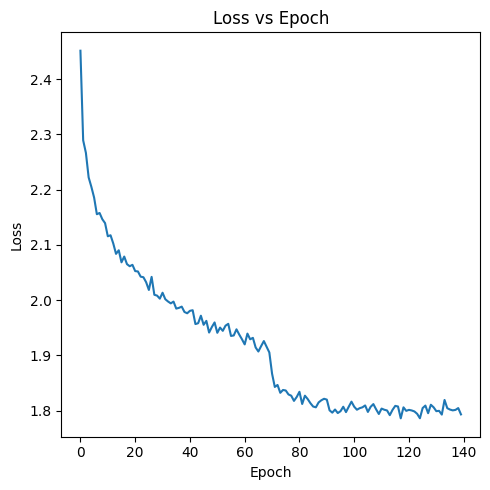

In [38]:
avg_loss: Tensor = (
    torch.tensor(losses_all, dtype=torch.float32).view(-1, 1_000).mean(dim=1)
)


fig, ax = plt.subplots(figsize=(5, 5))  # Create figure and axes
ax.plot(avg_loss)  # Plot the data
ax.set(xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch")  # Add labels
plt.tight_layout()
plt.show()

In [39]:
# Sample from the model
g = torch.Generator().manual_seed(5)
n_names: int = 20

# Set the training mode to False
for layer in model.layers:
    if hasattr(layer, "training"):
        layer.training = False


for _ in range(n_names):

    out: list[str] = []
    context: list[int] = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        x: Tensor = torch.tensor([context])

        logits: Tensor = model(x)
        probs: Tensor = F.softmax(logits, dim=1)
        # sample from the distribution
        idx: int = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [idx]
        out.append(idx)
        # If we sample the special '.' token, break
        if idx == 0:
            break

    # Decode and print the generated word
    print("".join(num_to_text.get(i) for i in out))

karyia.
kamarie.
margavious.
shrithy.
chafp.
alaikn.
mikena.
medalyn.
cinda.
jeden.
kodi.
terrale.
noama.
odecia.
zahaay.
talil.
sidney.
gily.
orgin.
stefane.
